In [35]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt


In [36]:
# Function to create transects by selecting points around target theta2 values
def create_transects_around_target_theta2(point_cloud, target_theta2_values, theta_range=1.5):
    return [point_cloud[(point_cloud['theta'] >= target_theta2 - theta_range) & 
                        (point_cloud['theta'] <= target_theta2 + theta_range)] 
            for target_theta2 in target_theta2_values]

# Function to check if all values in the point_cloud_df have been assigned to a transect
def check_unassigned_points(point_cloud_df, transects):
    assigned_points = pd.concat(transects)
    return point_cloud_df[~point_cloud_df.index.isin(assigned_points.index)].shape[0]


In [37]:
# Load point cloud
# map_naam = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Lidar\Alignment_test\HybridDune_Pcl_0001_01_1970__00_42_37.209.PCD"
# map_naam = r"D:\HybridDune\20241223_LiDAR1\Lidar1__Pcl_0023_12_2024__08_42_33.280.PCD"
map_naam = r"D:\HybridDune\20241223_LiDAR1\Lidar1__Pcl_0023_12_2024__11_37_45.280.PCD"
pcd = o3d.io.read_point_cloud(map_naam)
pcd

PointCloud with 7434 points.

## Transects ##

We first are going to label and or remove transects that we do not need. 

In [38]:
# # Extract points as a NumPy array
# xyz = np.asarray(pcd.points)

# # Convert to spherical coordinates with the z-axis as the reference axis
# x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
# rho = np.sqrt(x**2 + y**2 + z**2)
# phi = np.arctan2(y, x)
# theta_degrees = np.degrees(np.arccos(z / rho))

# # Create a DataFrame to store the point cloud data along with theta values
# point_cloud_df = pd.DataFrame({'x': x, 'y': y, 'z': z, 'theta': theta_degrees})

# # Define the target theta2 values for each transect
# target_theta2_values = [97.2, 92.5, 90.0, 87.6, 84.9, 82.7, 80.4, 77.9, 75.7, 73.0, 70.9, 68.0, 66.0, 63.4, 60.9, 55.7]

# # Generate transects with theta2 values around the specified target values with increased range
# transects = create_transects_around_target_theta2(point_cloud_df, target_theta2_values, theta_range=1)

# # Rename the transects starting from 1 going to 16
# transect_names = [f'Transect {i}' for i in range(1, 17)]
# transect_dict = dict(zip(transect_names, transects))

# # Count the number of points in each transect
# transect_point_counts = {name: len(transect) for name, transect in transect_dict.items()}

# # Check for unassigned points
# unassigned_points_count = check_unassigned_points(point_cloud_df, transects)
# if unassigned_points_count > 0:
#     print(f"Unassigned points count: {unassigned_points_count}")



## RD Coordinates ##

We transfrom the point cloud to RD-coordinate system, so that we can compare the point cloud with the lidar drone and individual GPS (GNSS) measuremetns. We obtain the Transformation matrix from the cloudcompare georeferencing. 

In [39]:
# # Extract points as a NumPy array
# xyz = np.asarray(pcd.points)
# x = xyz[:, 0]
# y = xyz[:, 1]
# z = xyz[:, 2]

# plt.scatter(-y,-x)
# plt.grid()

In [40]:
## Transformation matrix (CloudCompare)
# With scale + offset 
# transformation_matrix = np.array([
#     [-0.000002074866,  0.000818847970, -0.000601161388, 492.144012451172],
#     [-0.000004461102, -0.000601164182, -0.000818836386, 127.256645202637],
#     [-0.001015818445,  0.000000967538,  0.000004823944,   4.873136043549],
#     [ 0.000000000000,  0.000000000000,  0.000000000000,   1.000000000000]
# ])

# transformation_matrix = (1/1000)* np.array([
#     [-0.002105899155,  0.806553781033, -0.591156959534,  9317.809570312500],
#     [-0.004768516868, -0.591159582138, -0.806540489197, -5470.220703125000],
#     [-0.999986350536,  0.001120448112,  0.005090989172,  3098.181152343750],
#     [ 0.000000000000,  0.000000000000,  0.000000000000,     1.000000000000]
# ])

# transformation_matrix = np.array([
#     [-0.016750458628,  0.813058018684, -0.581941604614,  1810.331054687500],
#     [ 0.013758120127, -0.581780731678, -0.813229322433,   582.778381347656],
#     [-0.999765038490, -0.021628387272, -0.001441056258,  1353.261962890625],
#     [ 0.000000000000,  0.000000000000,  0.000000000000,     1.000000000000]
# ])

transformation_matrix = np.array([
    [-0.000016770196,  0.000814016035, -0.000582627312,  492.124877929688],
    [ 0.000013774332, -0.000582466251, -0.000814187515,  127.395973205566],
    [-0.001000943012, -0.000021653870, -0.000001442754,    4.594210147858],
    [ 0.000000000000,  0.000000000000,  0.000000000000,    1.000000000000]
])

transformation_matrix[0,3]+=  72000.00 
transformation_matrix[1,3]+=  452000.00
transformation_matrix[3,3]=1

print(transformation_matrix)
pcd = pcd.transform(transformation_matrix)

[[-1.67701960e-05  8.14016035e-04 -5.82627312e-04  7.24921249e+04]
 [ 1.37743320e-05 -5.82466251e-04 -8.14187515e-04  4.52127396e+05]
 [-1.00094301e-03 -2.16538700e-05 -1.44275400e-06  4.59421015e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [41]:
# add gps points to pcd

# GPS points data (x, y, z)
gps_points = np.array([
    [72494.499, 452122.918, 2.810],  # s1 gcp7
    [72484.236, 452134.838, 1.728],  # s1 gcp4
    [72484.496, 452132.319, 1.824],  # s1 gcp5
    [72480.801, 452131.708, 1.639],  # s1 gcp6
    [72492.062, 452127.310, 4.577],  # s1 lidar
    [72502.560, 452119.249, 5.333],  # s1 gcp1
    [72501.926, 452116.584, 5.689],  # s1 gcp2
    [72499.695, 452115.295, 5.540]   # s1 gcp3
])

labels = ["gcp7", "gcp4", "gcp5", "gcp6", "lidar", "gcp1", "gcp2", "gcp3"]

# Extract x, y, z for plotting
x_gps = gps_points[:, 0]
y_gps = gps_points[:, 1]
z_gps = gps_points[:, 2]

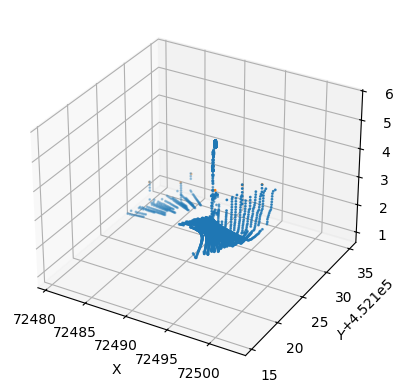

In [42]:
# Extract points as a NumPy array
xyz = np.asarray(pcd.points)
x = xyz[:, 0]
y = xyz[:, 1]
z = xyz[:, 2]


# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z, s=1)
ax.scatter(x_gps,y_gps,z_gps, s=1)
# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show plot
plt.show()

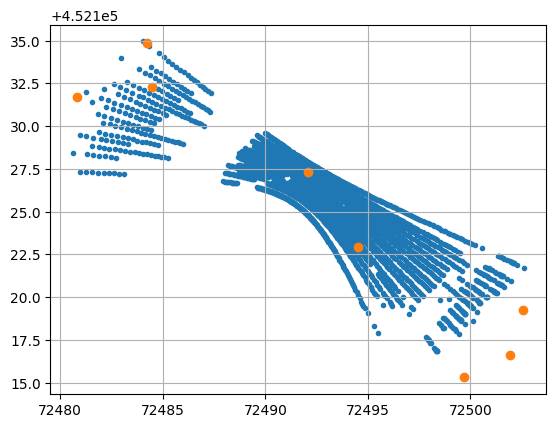

In [43]:
plt.figure()
plt.scatter(x,y, marker='.')
plt.scatter(x_gps,y_gps)
plt.grid()
# plt.ylim(0,6)
# plt.xlim(-335,-320)

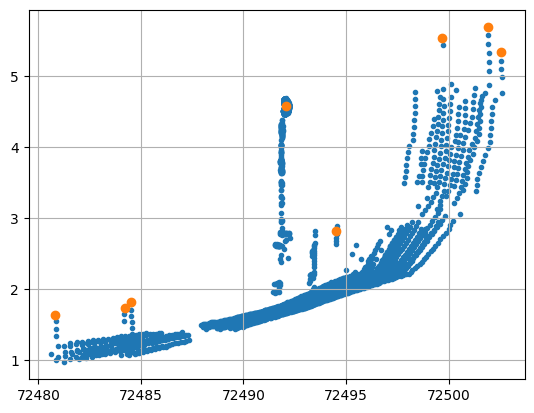

In [44]:
plt.figure()
plt.scatter(x,z, marker='.')
plt.scatter(x_gps,z_gps)
plt.grid()
# plt.ylim(0,6)
# plt.xlim(-335,-320)

In [45]:
# # Compute the translation back offsets for X and Y only
# translation_back = np.eye(4)
# translation_back[0, 3] = -transformation_matrix[0, 3]
# translation_back[1, 3] = -transformation_matrix[1, 3]

# # Apply the translation back to the origin for X and Y
# pcd.transform(translation_back)

# # Extract the rotation angle around the Z-axis
# theta_z = np.arctan2(transformation_matrix[1, 0], transformation_matrix[0, 0])

# # Create a reverse rotation matrix for the Z-axis
# cos_theta_z = np.cos(theta_z)
# sin_theta_z = np.sin(theta_z)
# rotation_z_matrix = np.array([
#     [cos_theta_z, -sin_theta_z, 0, 0],
#     [sin_theta_z, cos_theta_z,  0, 0],
#     [0,           0,            1, 0],
#     [0,           0,            0, 1]
# ])

# # Apply the reverse rotation around the Z-axis
# pcd.transform(rotation_z_matrix)

In [46]:
# Coordinates of the two points in the RD-coordinate system
point1 = np.array([72462.703, 452067.267, 4.101,1]) #point3
point2 = np.array([72448.355, 452047.630, 4.075,1]) #point4 

# Step 1: Compute the direction vector
direction = point1 - point2

# Step 2: Project the direction vector onto the XY-plane
direction_xy = direction[:2]  # Only consider the X and Y components

# Step 3: Compute the angle to the Y-axis
angle = np.arctan2(direction_xy[0], direction_xy[1])   # atan2(X, Y)

# Step 4: Construct the rotation matrix for rotation around the Z-axis
rotation_matrix = np.array([
    [np.cos(angle), -np.sin(angle), 0,0],
    [np.sin(angle),  np.cos(angle), 0,0],
    [0,              0,             1,0],
    [0,           0,            0, 1]
])

# Print the rotation matrix
print("Rotation Matrix (around Z-axis):")
print(rotation_matrix)

new_point1 = np.dot(rotation_matrix, point1)
new_point2 = np.dot(rotation_matrix, point2)

print(f'point1 = {point1} and in new system this is {new_point1}')
print(f'point2 = {point2} and in new system this is {new_point2}')

pcd.transform(rotation_matrix)

Rotation Matrix (around Z-axis):
[[ 0.80743256 -0.58995989  0.          0.        ]
 [ 0.58995989  0.80743256  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
point1 = [7.24627030e+04 4.52067267e+05 4.10100000e+00 1.00000000e+00] and in new system this is [-2.08192808e+05  4.07763917e+05  4.10100000e+00  1.00000000e+00]
point2 = [7.2448355e+04 4.5204763e+05 4.0750000e+00 1.0000000e+00] and in new system this is [-2.08192808e+05  4.07739596e+05  4.07500000e+00  1.00000000e+00]


PointCloud with 7434 points.

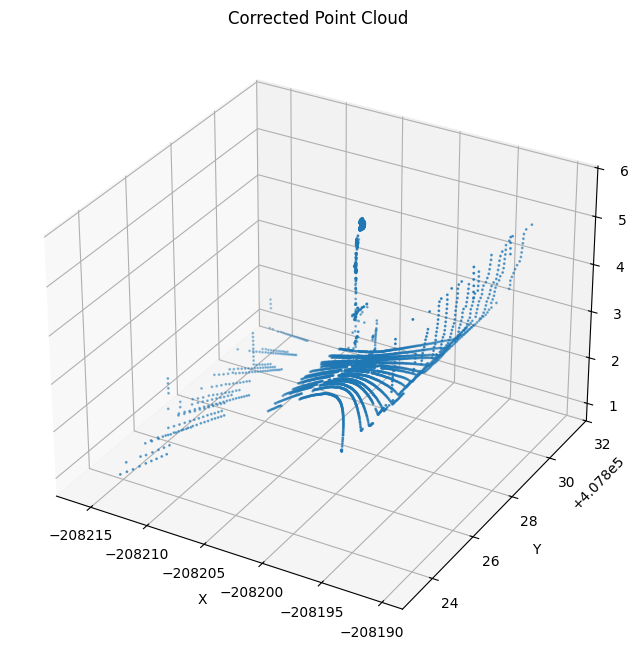

In [47]:
# Visualize the corrected point cloud
xyz = np.asarray(pcd.points)
x = xyz[:, 0]
y = xyz[:, 1]
z = xyz[:, 2]

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=1)

# plt.plot()

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Corrected Point Cloud')

plt.show()

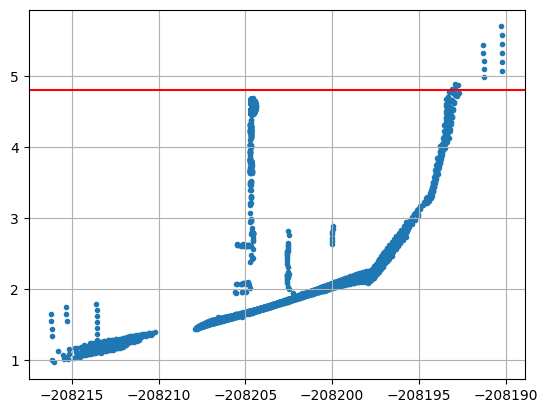

In [55]:
plt.figure()
plt.scatter(x,z, marker='.')
plt.grid()
plt.axhline(4.8, color='r')
# plt.ylim(1,6)
# plt.xlim(320,335)

In [49]:
# # Visualize the corrected point cloud
# xyz = np.asarray(pcd.points)
# longshore = xyz[:, 0]
# crosshore = xyz[:, 1]
# z = xyz[:, 2]

# plt.scatter(crosshore,z)
# plt.grid()

## Transects ##
Now that we have transformed the matrix to RD-coordinates and rotated it back to the new coordinate system (longshore, crosshore, NAP), we can filter the transects and further investigate Transect_03 as this is the zero degree transect (Crosshore orientated). 

In [50]:
# Convert to spherical coordinates with the x-axis as the reference axis
x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
rho = np.sqrt(x**2 + y**2 + z**2)
phi = np.arctan2(y, z)
theta_degrees = np.degrees(np.arccos(x / rho))

# Create a DataFrame to store the point cloud data along with theta values
point_cloud_df = pd.DataFrame({'x': x, 'y': y, 'z': z, 'theta': theta_degrees})

# Define the target theta2 values for each transect
target_theta2_values = [97.2, 92.5, 90.0, 87.6, 84.9, 82.7, 80.4, 77.9, 75.7, 73.0, 70.9, 68.0, 66.0, 63.4, 60.9, 55.7]

# Generate transects with theta2 values around the specified target values with increased range
transects = create_transects_around_target_theta2(point_cloud_df, target_theta2_values, theta_range=5)

# Rename the transects starting from 1 going to 16
transect_names = [f'Transect {i}' for i in range(1, 17)]
transect_dict = dict(zip(transect_names, transects))

# Count the number of points in each transect
transect_point_counts = {name: len(transect) for name, transect in transect_dict.items()}

# Check for unassigned points
unassigned_points_count = check_unassigned_points(point_cloud_df, transects)
if unassigned_points_count > 0:
    print(f"Unassigned points count: {unassigned_points_count}")

# Calculate and print the average value of each transect
for name, transect in transect_dict.items():
    avg_x = transect['x'].mean()
    avg_y = transect['y'].mean()
    avg_z = transect['z'].mean()
    avg_theta = transect['theta'].mean()
    print(f"{name} - Average x: {avg_x}, Average y: {avg_y}, Average z: {avg_z}, Average theta: {avg_theta}")


Unassigned points count: 7434
Transect 1 - Average x: nan, Average y: nan, Average z: nan, Average theta: nan
Transect 2 - Average x: nan, Average y: nan, Average z: nan, Average theta: nan
Transect 3 - Average x: nan, Average y: nan, Average z: nan, Average theta: nan
Transect 4 - Average x: nan, Average y: nan, Average z: nan, Average theta: nan
Transect 5 - Average x: nan, Average y: nan, Average z: nan, Average theta: nan
Transect 6 - Average x: nan, Average y: nan, Average z: nan, Average theta: nan
Transect 7 - Average x: nan, Average y: nan, Average z: nan, Average theta: nan
Transect 8 - Average x: nan, Average y: nan, Average z: nan, Average theta: nan
Transect 9 - Average x: nan, Average y: nan, Average z: nan, Average theta: nan
Transect 10 - Average x: nan, Average y: nan, Average z: nan, Average theta: nan
Transect 11 - Average x: nan, Average y: nan, Average z: nan, Average theta: nan
Transect 12 - Average x: nan, Average y: nan, Average z: nan, Average theta: nan
Transec

C:\Users\ruro\AppData\Local\Temp\ipykernel_16996\1383488488.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', 16)


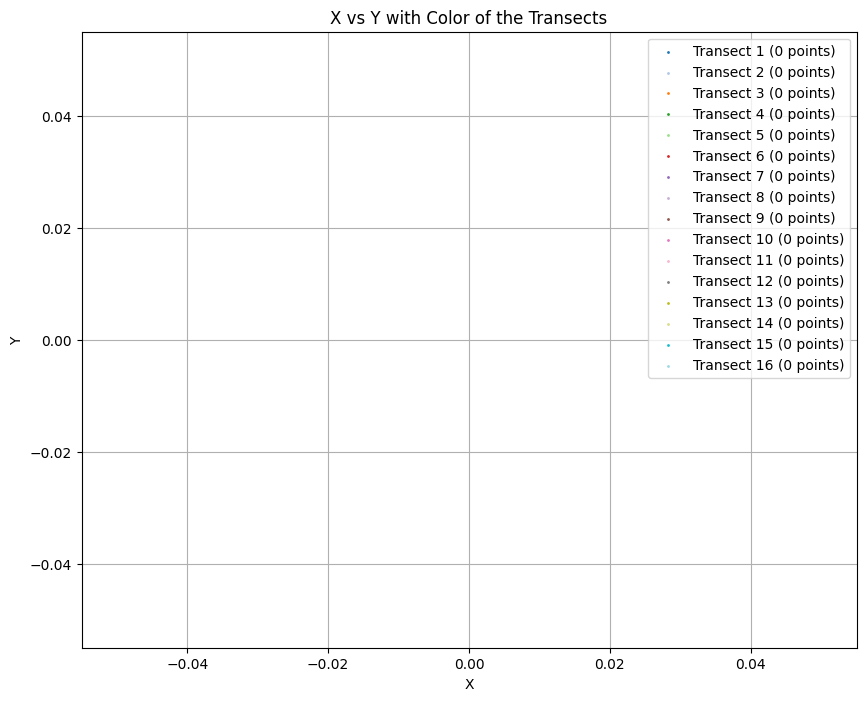

In [51]:
# Plot x vs y with color of the transects
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab20', 16)

for i, (name, transect) in enumerate(transect_dict.items()):
    plt.scatter(transect['x'], transect['y'], color=colors(i), label=f"{name} ({transect_point_counts[name]} points)", s=1)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('X vs Y with Color of the Transects')
plt.grid(True)
plt.legend()
plt.show()
